In [1]:
import glob
import os 
import densmap as dm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# Exploration parameters
a = 0.2
n = 14
ca = 0.125

In [3]:
workdir = 'WorkdirRoughMeniscus/'
file_root = 'flow_'

In [4]:
# Input and output files
a_tag = str(a).replace('.','').ljust(2,'0')
n_tag = str(n).rjust(2,'0')
c_tag = str(10*ca).replace('.','').ljust(3,'0')
file_tag = 'N'+n_tag+'A'+a_tag+'C'+c_tag
folder_name = workdir+file_tag+'/'

In [5]:
Lx = 82.80000
Lz = 28.00000
Lx4 = Lx/4
waven  = 2*np.pi*n/Lx4
height = a/waven
phi_0  = 0
h_0    = 3.0
fun_sub = lambda x : height * np.sin(waven*x+phi_0) + h_0

In [6]:
# Automagically finding the index of the first and last file
dat_file_list = sorted([os.path.basename(x) for x in glob.glob(folder_name+'*.dat')])

### TEST ###
assert len(dat_file_list) > 0, "Empty directory!"

print(min([os.stat(x).st_size for x in glob.glob(folder_name+'*.dat')]))
assert min([os.stat(x).st_size for x in glob.glob(folder_name+'*.dat')]) > 0, "Corrupted output!"
n_init = int(dat_file_list[0][5:10].lstrip("0"))
n_fin = int(dat_file_list[-1][5:10].lstrip("0"))

891140


In [7]:
# Creating the meshgrid
density_array = dm.read_density_file(folder_name+'/'+file_root+'{:05d}'.format(n_init)+'.dat', bin='y')
Nx = density_array.shape[0]
Nz = density_array.shape[1]
hx = Lx/Nx
hz = Lz/Nz
x = hx*np.arange(0.0,Nx,1.0, dtype=float)+0.5*hx
z = hz*np.arange(0.0,Nz,1.0, dtype=float)+0.5*hz
X, Z = np.meshgrid(x, z, sparse=False, indexing='ij')

In [8]:
z_min = 5
z_max = 15
z_ref = 10

In [9]:
# INITIALIZATION
xc = np.sum(np.multiply(density_array[:,int(z_ref//hz)+1],x))/np.sum(density_array[:,int(z_ref//hz)+1])
dxc = 0.5*Lx-xc
density_array = np.roll(density_array, shift=int(dxc//hx), axis=0)
left_int, right_int = dm.detect_interface_loc(density_array, hx, hz, z_min, z_max, wall='l')

(-1.3877787807814457e-17, 82.79999999999998, -1.3877787807814457e-17, 28.0)

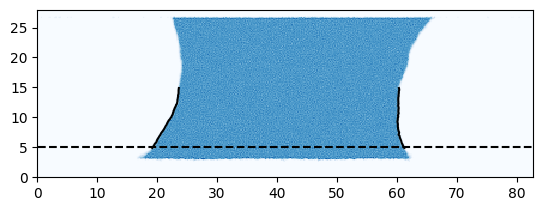

In [10]:
%matplotlib inline
plt.pcolormesh(X, Z, density_array, cmap=cm.Blues, vmax=1000)
plt.plot([x[0],x[-1]],[z_min,z_min],'k--')
plt.plot(left_int[0],left_int[1],'k-')
plt.plot(right_int[0],right_int[1],'k-')
plt.axis('scaled')

In [11]:
dt = 12.5
delta_th = 2.0
t = []
xcom = []
lcl = []
rcl = []

Obtainig frame 50
18.733808180179423 | 42.32589828868299 | 62.71351620864706
Obtainig frame 100
18.69849805867943 | 43.3532173315957 | 63.642031594604006
Obtainig frame 150
17.825516041890424 | 43.09042728746265 | 63.31880715470314
Obtainig frame 200
17.983209555040617 | 43.54246547544467 | 63.58431144115349
Obtainig frame 250
18.23763806350181 | 43.818767819751464 | 65.19184488003313
Obtainig frame 300
16.93487830552472 | 44.30303007442468 | 66.34403439342104
Obtainig frame 350
15.548346333695765 | 44.103858156361355 | 66.14573310116998
Obtainig frame 400
14.699578229847571 | 44.75254052654413 | 67.32640092536609
Obtainig frame 450
14.365888811453086 | 46.20942900338296 | 68.99214646326244
Obtainig frame 500
14.957320686580912 | 47.844624246250135 | 70.46621872582769
Obtainig frame 550
16.153629887154487 | 48.44675873264811 | 70.76651457554526
Obtainig frame 600
17.462119260506807 | 49.47196949228838 | 71.89227382783525
Obtainig frame 650
16.235944599306162 | 49.521030492498134 | 71.0

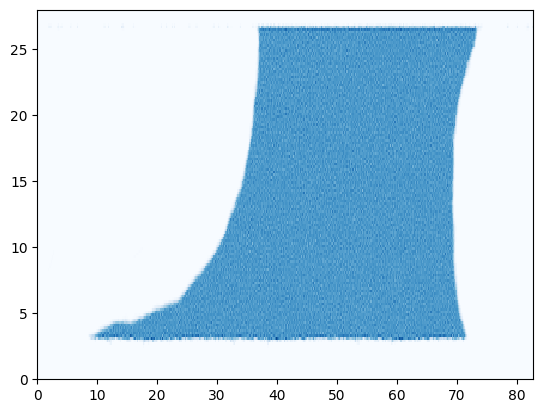

In [12]:
%matplotlib inline
n_dump = 50
for idx in range(n_init, n_fin):
    if idx%n_dump==0 :
        print("Obtainig frame "+str(idx))
        
    ### TEST ###
    try:
        density_array = dm.read_density_file(folder_name+'/'+file_root+'{:05d}'.format(idx)+'.dat', bin='y')
    except ValueError as e:
        print ('! Corrupted output !')
    
    density_array = np.roll(density_array, shift=int(dxc//hx), axis=0)
    xc = np.sum(np.multiply(density_array[:,int(z_ref//hz)+1],x))/np.sum(density_array[:,int(z_ref//hz)+1])
    dxc = 0.5*Lx-xc
    # density_array = np.roll(density_array, shift=int(dxc//hx), axis=0)
    left_int, right_int = dm.detect_interface_loc(density_array, hx, hz, z_min, z_max, wall='l')
    if left_int[0][0]>right_int[0][0] :
        break
    if idx%n_dump==0 :
        print(left_int[0][0],'|',xc,'|',right_int[0][0])
    t.append((1e-3)*idx*dt)
    xcom.append(xc)
    lcl.append(left_int[0][0])
    rcl.append(right_int[0][0])
plt.pcolormesh(X, Z, density_array, cmap=cm.Blues, vmax=1000)

Text(0, 0.5, '$\\Delta_{ls}x_{cl}$ [nm]')

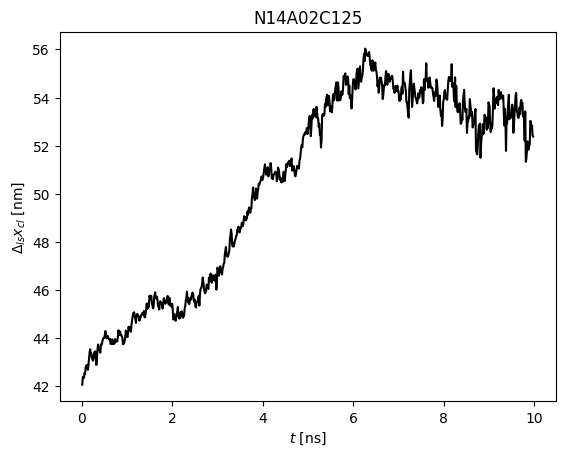

In [13]:
%matplotlib inline
lcl = np.array(lcl)
rcl = np.array(rcl)
dcl = rcl-lcl
t = np.array(t)
# plt.plot(t,lcl,'b-')
# plt.plot(t,rcl,'r-')
plt.title(file_tag)
plt.plot(t,dcl,'k-')
plt.xlabel(r"$t$ [ns]")
plt.ylabel(r"$\Delta_{ls}x_{cl}$ [nm]")

In [14]:
# Saving
np.savez(workdir+file_tag+'.npz', t, dcl)